# CodeLab 2 - Regression models for load forecast

In this CodeLab, provided data set contains historical Netherland's hourly demand profile and day ahead forecast collected from Entso-E and weather data collected from NASA Merra. 

In [1]:
#Import Libraries
import numpy as np 
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
import time
import pickle

# Task 1: Load energy data 

“Data.csv” file contains all related information and can be loaded/read using Pandas library. Pandas library is a useful library for investigating and processing datasets. 

<br>-Load the dataset using “pandas.read_csv” function.

In [2]:
#Load input csv file with pandas
Input = pd.read_csv('Data.csv', delimiter=';') #01.01.2019-Tuesday 

In [3]:
Input

,day,month,hours,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_mass,cloud_cover,air_density,Forecast load (MW),Actual load (MW),Positive imbalance price (Eur/MWh),Negative imbalance price (Eur/MWh)
0,1,1,0,0.0349,7.196,0.0,0.0,0.0000,0.0000,0.9970,1.2738,12390.75,11284.75,14.50,38.90
1,1,1,1,0.0373,7.278,0.0,0.0,0.0000,0.0000,0.9981,1.2730,11810.00,11193.75,0.00,36.48
2,1,1,2,0.0459,7.364,0.0,0.0,0.0000,0.0000,0.9973,1.2720,11410.50,10933.25,29.30,34.19
3,1,1,3,0.0528,7.415,0.0,0.0,0.0000,0.0000,0.9907,1.2711,11309.00,10666.75,21.66,27.21
4,1,1,4,0.0628,7.503,0.0,0.0,0.0000,0.0000,0.9665,1.2699,11420.25,10413.25,0.00,30.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,31,12,19,0.0104,3.090,0.0,0.0,0.0000,0.0000,0.8590,1.3002,12945.50,14247.75,0.00,12.22
8756,31,12,20,0.0154,2.789,0.0,0.0,0.0000,0.0000,0.8434,1.3037,12379.75,13517.25,0.00,24.20
8757,31,12,21,0.0152,2.327,0.0,0.0,0.0000,0.0000,0.8357,1.3064,11820.25,12799.25,17.03,17.50
8758,31,12,22,0.0143,1.858,0.0,0.0,0.0000,0.0000,0.8775,1.3085,11163.00,12064.25,0.00,2.51


-Find the date and hour that corresponds to the maximum electricity consumption.
<br> -Plot the following variables for the entire day (00:00-23:00) of the maximum consumption in subplots. Subplot 1: Actual load (MW) and Forecasted load (MW), subplot 2: temperature, subplot 3: irradiance_surface, and subplot 4: snowfall. The X-axis of all subplots is the hour of the day.
<br>Hint: Dataframe.columns print out the column names of the data frame.

In [4]:
index_max_day = np.argmax(Input["Actual load (MW)"])
print(index_max_day)
max_day = Input.iloc[index_max_day,0]
print(max_day)
max_month = Input.iloc[index_max_day,1]
print(max_month)
Data_max_day = Input.iloc[index_max_day,2]
print(Data_max_day)

521
22
1
17


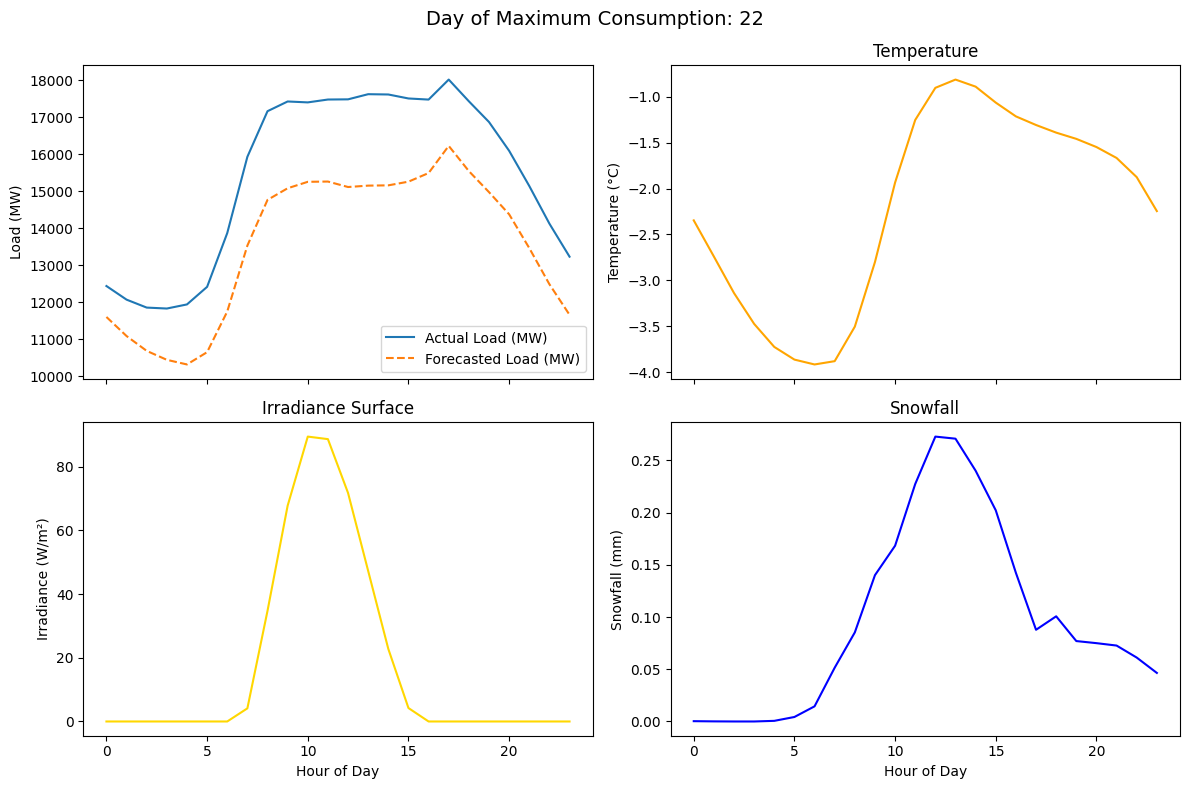

In [5]:

max_actualPower = Input.loc[(Input['day'] == max_day) & (Input['month'] == max_month),['Actual load (MW)']]
max_forecastPower = Input.loc[(Input['day'] == max_day) & (Input['month'] == max_month),['Forecast load (MW)']]
max_temperature = Input.loc[(Input['day'] == max_day) & (Input['month'] == max_month),['temperature']]
max_irradiance = Input.loc[(Input['day'] == max_day) & (Input['month'] == max_month),['irradiance_surface']]
max_snowfall = Input.loc[(Input['day'] == max_day) & (Input['month'] == max_month),['snowfall']]
max_hours = Input.loc[(Input['day'] == max_day) & (Input['month'] == max_month),['hours']]

# 3. Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle(f"Day of Maximum Consumption: {max_day}", fontsize=14)

# Subplot 1: Actual vs Forecasted Load
axs[0, 0].plot(max_hours, max_actualPower, label="Actual Load (MW)")
axs[0, 0].plot(max_hours, max_forecastPower, label="Forecasted Load (MW)", linestyle="--")
axs[0, 0].set_ylabel("Load (MW)")
axs[0, 0].legend()

# Subplot 2: Temperature
axs[0, 1].plot(max_hours, max_temperature, color="orange")
axs[0, 1].set_ylabel("Temperature (°C)")
axs[0, 1].set_title("Temperature")

# Subplot 3: Irradiance
axs[1, 0].plot(max_hours, max_irradiance, color="gold")
axs[1, 0].set_ylabel("Irradiance (W/m²)")
axs[1, 0].set_xlabel("Hour of Day")
axs[1, 0].set_title("Irradiance Surface")

# Subplot 4: Snowfall
axs[1, 1].plot(max_hours, max_snowfall, color="blue")
axs[1, 1].set_ylabel("Snowfall (mm)")
axs[1, 1].set_xlabel("Hour of Day")
axs[1, 1].set_title("Snowfall")

plt.tight_layout()
plt.show()

The process of training a machine learning model relies on data or features. Properly prepared features are essential for learning. Real life applications requires knowledge on data and models, this process is called as feature engineering which will be covered in CodeLab 4. In this CodeLab, you will work on these 3 different feature matrices X_1, X_2, and X_3. Use the following pickle command to load the dictionary "D" which contains features and the target variable. 
<br> -Print the keys of dictionary with ".keys()" function.
<br> -Extract the contents of the dictionary in following variables X_1, X_2, C, and y.


In [6]:
D = pickle.load(open('file.pkl', 'rb'))
print(D.keys())

dict_keys(['Feature1', 'Feature2', 'Categorical', 'Target'])


In [7]:
y = D["Target"]
X_1 = D["Feature1"]
X_2 = D["Feature2"]
C = D["Categorical"]

"Feature1" (X_1) contains previous load demand and weather predictions. "Feature2" (X_2) has the full content of "Feature1" and the load forecast values from Entso-E. "Categorical" (C) features represent the categorical time element of the data in a one-hot encoded way. For example, C[i]=[100001100] represents data is taken from a weekend in the fall season and a daytime (07:00-16:00) load. Details regarding one-hot encoding and the structure of C is included in the bonus task of CodeLab. "Target" contains the target variable (y) of the ML model. Further details are explained in the PDF document. 
<br> -Calculate the sparsity of X_1, X_2, and C. 

In [8]:
sparsity_X1 = np.count_nonzero(X_1 == 0) / X_1.size
sparsity_X2 = np.count_nonzero(X_2 == 0) / X_2.size
sparsity_C = np.count_nonzero(C == 0) / C.size
print("sparsity X1")
print(sparsity_X1)
print("sparsity X2")
print(sparsity_X2)
print("sparsity C")
print(sparsity_C)

sparsity X1
0.2159880389628993
sparsity X2
0.20056032189412076
sparsity C
0.6666666666666666


#### Questions
<br>1)	What is the difference between the forecasted and actual loads at the hour of the maximum consumption?
<br>2)  What do you observe from the generated subplots? 
<br>3)  Which features in the subplots might be good features for the machine learning model and why?
<br>4)  Calculate and write the sparsity of C. 
<br>5)  Explain why to use encoding instead numeric date values in a regression problem.
<br>6)  Explain why we need the time information for the load forecast problem.
<br>7)  Why is it important to calculate sparsity? What does it mean to have a high/low sparsity and how it would affect the regression?

# Task 2: Process data and prepare for machine learning algorithms

In this task, you will generate all feature sets and standardize or scale the data for the training process. 

<br>The standardization process is essential for many machine learning models. For instance, many algorithms (such as the RBF kernel of Support Vector Machines) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate and make the estimator unable to learn from other features correctly as expected [Sklearn StandardScaler-https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html] . 

<br>Features are standardized by removing the mean and scaling to unit variance. This process is called standard scaling or z normalization. 

<br> z = (x-u)/s where u is the mean of feature and s is the standard deviation.

<br> -Use sklearn StandardScaler to scale X_1.
<br> -Define a new scaler to scale X_2.
<br> -Concatenate categorical variable matrix C to scaled X_2 which will generate the third feature set X_3. 
<br> X_1 = [Weather(t), Historical_demand(t-x)], X_2 = [X_1, Forecast], X_3 = [X_2scaled, C]

In [9]:
#Feature scaling
scaler1 = StandardScaler().fit_transform(X_1)
scaler2 = StandardScaler().fit_transform(X_2)
X_1scaled = scaler1
X_2scaled = scaler2
X_3scaled = np.hstack((scaler2,C))

The dataset must be split into training and test sets. 25% of the data will be used for test proposes. To generate reproducible results, please use the given Shuffle_state variable as a random state of the splitter function. Note: When you call the Shuffle_state, y_train, and y_test (target variables) from different splits will be the same.
<br>-Split X_1, X_2 and X_3 using Sklearn train_test_split() function into 3 training and 3 test data
<br>-Print out the mean of X_1, scaled X_1, training data X_1 (scaled), and test data X_1 (scaled).

In [10]:
#Train test split
Test_ratio = 0.25
Shuffle_state = 4720
X_train1, X_test1, y_train, y_test = train_test_split(X_1scaled,y,test_size=Test_ratio,random_state=Shuffle_state)

X_train2, X_test2, y_train, y_test = train_test_split(X_2scaled,y,test_size=Test_ratio,random_state=Shuffle_state)

X_train3, X_test3, y_train, y_test = train_test_split(X_3scaled,y,test_size=Test_ratio,random_state=Shuffle_state)

print("Mean of X_1 = %.3f" % X_1.mean())
print("Mean of scaled X_1 = %.3f" % X_1scaled.mean())
print("Mean of scaled X_train1 = %.3f" % X_train1.mean())
print("Mean of scaled X_test1 = %.3f" % X_test1.mean())

Mean of X_1 = 5030.273
Mean of scaled X_1 = 0.000
Mean of scaled X_train1 = -0.001
Mean of scaled X_test1 = 0.004


#### Questions
<br> 1) Why do you use 2 different scalers? What happens if the first one used for to scale X_2 as well?
<br> 2) Why categorical variables are not scaled?

# Task 3: Training and evaluation of linear regressors

In this CodeLab, different regression models are implemented. Using linear regression models, you should identify the best feature set to investigate further. After the most appropriate feature set is identified, regularization on linear regression is investigated through Ridge and Lasso models.

#### Linear Regression:
-Construct and train three linear regression models using feature sets X_1, X_2 and X_3.
<br> -Define a function test_mymodel(model,X_test,y_test) to evaluate the model performance. Function takes model, test features and test target variable (label), output is R2 score and MSE. 
<br> -Evaluate models with test_mymodel and record the output.

In [11]:
#Linear regression models
lin_reg_1 = LinearRegression().fit(X_train1, y_train)
lin_reg_2 = LinearRegression().fit(X_train2, y_train)
lin_reg_3 = LinearRegression().fit(X_train3, y_train)

In [12]:
#Model evaluation function
def test_mymodel(model,X,y):
    y_pred = model.predict(X)
    MSE = mean_squared_error(y, y_pred)
    R2 = r2_score(y, y_pred)
    return MSE, R2

In [13]:
#Comparison of different feature sets
MSE=[]; R2=[]

MSE.append(test_mymodel(lin_reg_1, X_test1, y_test)[0])
MSE.append(test_mymodel(lin_reg_2, X_test2, y_test)[0])
MSE.append(test_mymodel(lin_reg_3, X_test3, y_test)[0])

print("MSE scores of linear regressors: "+str(MSE))

R2.append(test_mymodel(lin_reg_1, X_test1, y_test)[1])
R2.append(test_mymodel(lin_reg_2, X_test2, y_test)[1])
R2.append(test_mymodel(lin_reg_3, X_test3, y_test)[1])

print("R2 scores of linear regressors: " +str(R2))

MSE scores of linear regressors: [928883.9611758312, 622490.3838241054, 421009.82385786466]
R2 scores of linear regressors: [0.7511760412272825, 0.8332509462161521, 0.8872223706802829]


 -Plot  2 bar graphs for R2 and MSE of all linear regression models (Hint: use plt.ylim() to adjust limits for better visuals). 
<br> -Plot all predictions and test data together for the first 64 hours or between [0:63] sample points.
<br> -Print out the weigths of the best model and find the absolute maximum difference between weights. 

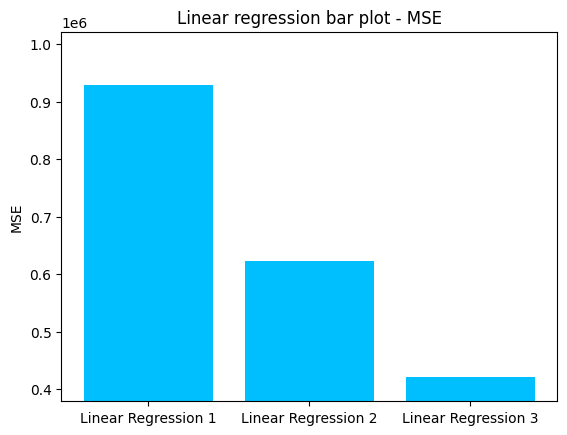

In [14]:
#MSE bar plot for linear regression 
low = min(MSE)*0.9
high = max(MSE)*1.1
name = ["Linear Regression 1", "Linear Regression 2", "Linear Regression 3"]
plt.ylabel('MSE')
plt.title("Linear regression bar plot - MSE" )
plt.bar(name, MSE,color='deepskyblue')
plt.ylim(low,high);

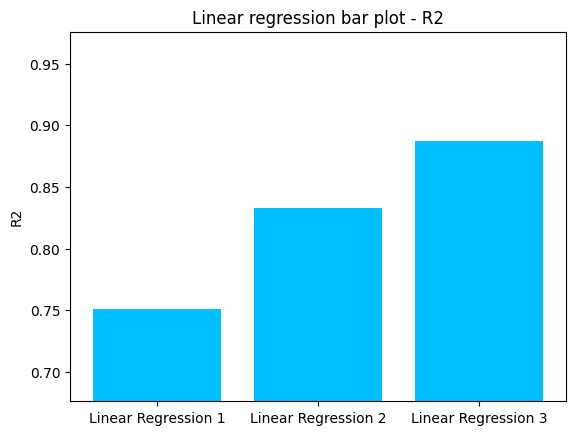

In [15]:
#R2 bar plot for linear regression 
low = min(R2)*0.9
high = max(R2)*1.1
name = ["Linear Regression 1", "Linear Regression 2", "Linear Regression 3"]
plt.ylabel('R2')
plt.title("Linear regression bar plot - R2" )
plt.bar(name, R2,color='deepskyblue')
plt.ylim(low,high);

(63,)


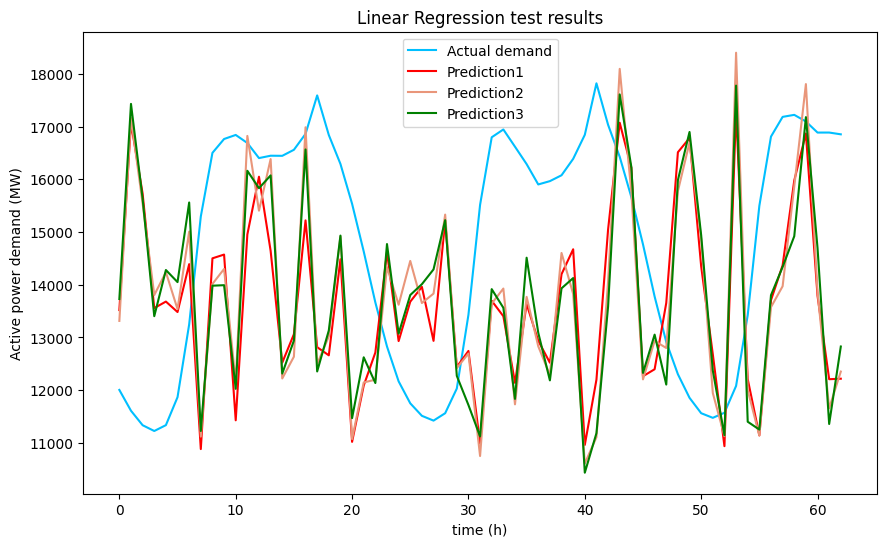

In [16]:
#Time series plot of prediction 
lin_predict_1 = lin_reg_1.predict(X_test1)
lin_predict_2 = lin_reg_2.predict(X_test2)
lin_predict_3 = lin_reg_3.predict(X_test3)
print(y[0:63].shape)
time_axis = np.arange(len(y[0:63]))
plt.figure(figsize=(10.24, 6.00))
plt.plot(time_axis, y[0:63], c='deepskyblue', label='Actual demand')
plt.plot(time_axis, lin_predict_1[0:63], c='r', label='Prediction1')
plt.plot(time_axis, lin_predict_2[0:63], c='darksalmon', label='Prediction2')
plt.plot(time_axis, lin_predict_3[0:63], c='g', label='Prediction3')

plt.xlabel('time (h)') 
plt.ylabel('Active power demand (MW)')
plt.title("Linear Regression test results")
plt.legend()
plt.show()

In [17]:
#Print coeffients
weight1 = lin_reg_1.coef_
weight2 = lin_reg_2.coef_
weight3 = lin_reg_3.coef_
abs_diff = np.abs(np.linalg.norm(weight2) - np.linalg.norm(weight3))
print("Best weights according to MSE(3rd model):")
print(weight3)
print("\n Absolute difference=%.2f" %abs_diff)

Best weights according to MSE(3rd model):
[   17.94423218  -326.42386824  -481.63566056   548.67731475
    25.5450198    -19.84711394    21.16472399  -132.01353121
  1013.44354774 -1043.45228794   165.50478211    96.80661346
   520.20716573   671.84417051  -425.22014807   425.22014807
  -196.66521128   -62.39361706   160.41813932    98.64068903
   291.96236016   525.61856801  -817.58092816]

 Absolute difference=164.28


#### Ridge & Lasso Regression:
Ridge & Lasso regression models are modified forms of linear regression. The complexity parameter alpha controls the complexity of the model. Adjust the alpha parameter to obtain the best results. Although alpha in both models adjusts the regularization in the optimization problem, their mathematical interpretations are different so same alpha values will have different effects in training. 
<br> -Train ridge and lasso regression models with alpha=0.1, using the best performing feature set in linear regression.
<br> -Test both models with test_mymodel() and record R2 and MSE values.
<br> -Train and test both models again with varying alpha values starting from 0.0005 to 1.0 with a step size equal to 0.005. Record R2 and MSE at each step.
<br> -Plot "alpha vs MSE" and "alpha vs R2" to find the best performing regularization parameter alpha and its effect on prediction.

Ridge and Lasso models construct an optimization problem, therefore for numerical stability we have scaled the target variable as well with the following code block. Please use the new y_train_s and y_test_s to fit and test models. Otherwise, convergence problems might be observed.

In [18]:
u = np.mean(y_train)
s = np.std(y_train)
y_train_s = (y_train-u)/s
y_test_s = (y_test-u)/s

In [19]:
#Ridge & Lasso Regression
Rid_reg= Ridge(alpha=1.0, random_state=42).fit(X_train3, y_train_s)
Las_reg = Lasso(alpha=0.1, random_state=42).fit(X_train3, y_train_s)

MSE_rid, R2_rid= test_mymodel(Rid_reg,X_test3,y_test_s)
MSE_las, R2_las = test_mymodel(Las_reg,X_test3,y_test_s)
print("MSE scores of ridge regressor: %.2f"%(MSE_rid))
print("MSE scores of lasso regressor: %.2f"%(MSE_las))
print("R2 scores of ridge regressors: %.5f"%(R2_rid))
print("R2 scores of lasso regressors: %.5f"%(R2_las))


MSE scores of ridge regressor: 0.11
MSE scores of lasso regressor: 0.23
R2 scores of ridge regressors: 0.88720
R2 scores of lasso regressors: 0.76927


In [20]:
alpha_list = np.linspace(0.0005,1,int(np.floor((1-0.0005)/0.0005)))
# Lists to store results
MSE_record_ridge = []
MSE_record_lasso = []
R2_record_ridge = []
R2_record_lasso = []

# Loop over alpha values
for alpha in alpha_list:
    # Create models with current alpha
    model_ridge = Ridge(alpha=alpha, random_state=42)
    model_lasso = Lasso(alpha=alpha, random_state=42)
    
    # Fit models
    model_ridge.fit(X_train3, y_train_s)
    model_lasso.fit(X_train3, y_train_s)
    
    # Evaluate using test_mymodel
    MSE_ridge, R2_ridge = test_mymodel(model_ridge, X_test3, y_test_s)
    MSE_lasso, R2_lasso = test_mymodel(model_lasso, X_test3, y_test_s)
    
    # Store results
    MSE_record_ridge.append(MSE_ridge)
    MSE_record_lasso.append(MSE_lasso)
    R2_record_ridge.append(R2_ridge)
    R2_record_lasso.append(R2_lasso)


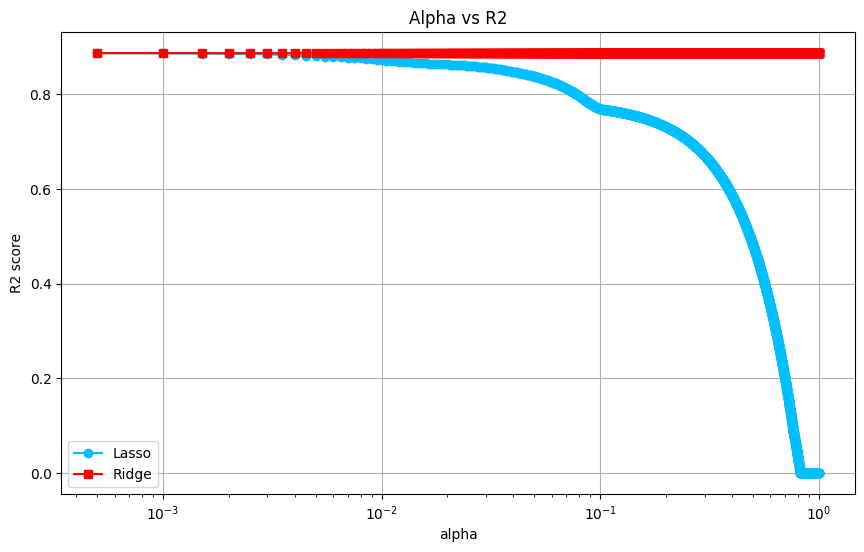

In [21]:
plt.figure(figsize=(10.24, 6.00))
# Plot Lasso R2 vs alpha
plt.plot(alpha_list, R2_record_lasso, c='deepskyblue', marker='o', label='Lasso')

# Plot Ridge R2 vs alpha
plt.plot(alpha_list, R2_record_ridge, c='r', marker='s', label='Ridge')

plt.xlabel('alpha') 
plt.ylabel('R2 score')
plt.title("Alpha vs R2")
plt.xscale('log')  # optional: use log scale for alpha
plt.legend()
plt.grid(True)
plt.show()

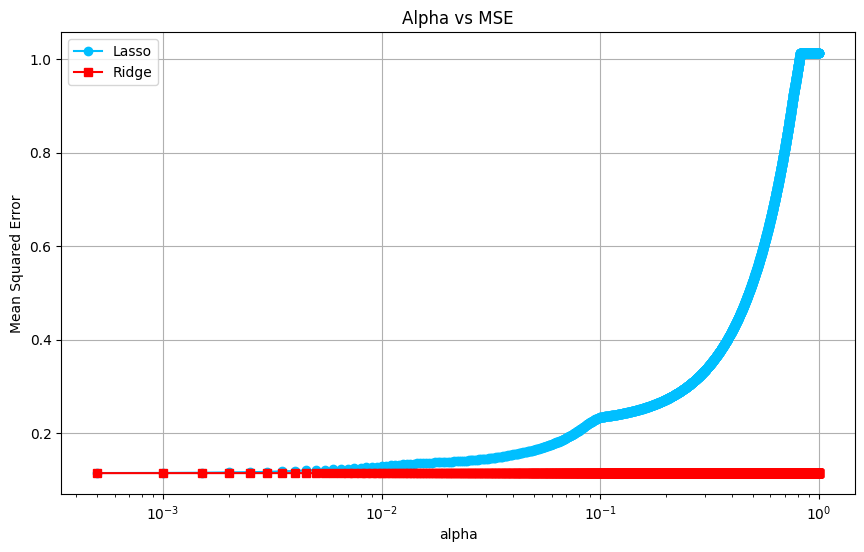

In [22]:
plt.figure(figsize=(10.24, 6.00))

# Plot Lasso MSE vs alpha
plt.plot(alpha_list, MSE_record_lasso, c='deepskyblue', marker='o', label='Lasso')

# Plot Ridge MSE vs alpha
plt.plot(alpha_list, MSE_record_ridge, c='r', marker='s', label='Ridge')

plt.xlabel('alpha') 
plt.ylabel('Mean Squared Error')
plt.title("Alpha vs MSE")
plt.xscale('log')  # optional: useful if alpha spans multiple orders of magnitude
plt.legend()
plt.grid(True)
plt.show()

#### Questions
<br> 1)	Record R2 and MSE scores of linear regression models, compare and comment on the results.
<br> 2)	What does MSE represent for the linear regression problem in this CodeLab?
<br> 3)	Which feature set gives the best prediction capability? 
<br> 4)	What is the absolute difference between the maximum and minimum weights of the best performing model? 
<br> 5)	What do weights correspond to in a linear regression?
<br> 6)	What is the role of alpha in Ridge and Lasso models?
<br> 7) Why is the MSE of Ridge & Lasso a thousand times smaller than the linear regression?
<br> 8)	Compare the results of regularized models with previous linear regressors.
<br> 9) What is the value of alpha that gives the smallest error in the test set?

# Task 4: Support Vector Machine

Support vector machines (SVMs) are supervised machine learning methods used for classification, regression and outliers detection.  This technique will be introduced in week 3. However, now you can treat it as a black box and try to play with it. If you are eager to find out what it is and how it works, this link may help you.

https://medium.com/cube-dev/support-vector-machines-tutorial-c1618e635e93


In this practicum SVM is investigated with different parameters and kernels. Kernels are decision functions which have been applied to transform the feature space into higher dimensions. Nonlinear relationships between features can be found in high dimensional space. 
<br> Compared to linear models construction of SVM is much more expensive. Time library can be utilized the measure the training time of SVM. For this task, please use again the scaled target variables for numerical stability. 
<br> -Construct a linear SVM regressor with default parameters and record R2, MSE and training time.
<br> Note: Add maximum iteration as 1e6 or 1e7 inside the model definition to avoid long training times.

In [23]:
#Time measurement 
#Put the start value at the beginning of the cell and put stop value at the end of the cell.
start = time.time()
svr_model = SVR().fit(X_train3,y_train_s)
stop = time.time()
print("Required Time= "+str(stop-start))

Required Time= 1.0833699703216553


In [24]:
#Linear SVM
start = time.time()
svm_lin = SVR(kernel='linear').fit(X_train3,y_train_s)
MSE_svmlin, R2_svmlin= test_mymodel(svm_lin,X_test3,y_test_s)
print("MSE scores of linear SVM: "+str(MSE_svmlin))
print("R2 scores of linear SVM: "+str(R2_svmlin))
stop = time.time()
print("Required Time for linear SVM seconds= "+str(stop-start))

MSE scores of linear SVM: 0.11654203034659039
R2 scores of linear SVM: 0.8849485318868058
Required Time for linear SVM seconds= 4.783957481384277


 -Conduct a grid search (apply all possible pairs) on C and epsilon with the given list of parameters. 
 
 <br>The model parameters that gives the highest R2 or the lowest MSE score will be used in next SVM models. (It is possible to observe different set of parameters for the lowest MSE and the highest R2. Please select one performance metric to find the most suitable hyperparameters.)
 
 <br>Hint: The grid search process can be done by nested loops. Construct 2 for loops to iterate each hyperparameter and train with different parameter combinations at each iteration. Lists are useful for recording performance metrics.

In [25]:
#SVM Grid search
start = time.time()
Regularization_list = np.linspace(0.0005,1,10)
epsilon_list = np.linspace(0.0005,1,10)
MSE_rec = [] ; R2_rec = []; C_rec = []; epsilon_rec=[]
for i in Regularization_list:
    for j in epsilon_list:
        # Create and train SVR
        model = SVR(kernel='linear', C=i, epsilon=j)
        model.fit(X_train3, y_train_s)

        MSE_tempModel, R2_tempModel= test_mymodel(model,X_test3,y_test_s)
        
        MSE_rec.append(MSE_tempModel)
        R2_rec.append(R2_tempModel)
        C_rec.append(i)
        epsilon_rec.append(j)
        
stop = time.time()
print("Required Time= "+str(stop-start))

Required Time= 112.45123338699341


In [26]:
#Find best parameters
max_R2 = max(R2_rec)
max_R2_ind = R2_rec.index(max(R2_rec))
C_best = C_rec[max_R2_ind]
epsilon_best = epsilon_rec[max_R2_ind]
print("best C value for optimizing R2:")
print(C_best)
print("best epsilon value for optimizing R2:")
print(epsilon_best)

best C value for optimizing R2:
1.0
best epsilon value for optimizing R2:
0.33366666666666667


-Write and compare results of default and tuned linear SVMs. Print selected parameters and performance metrics. 

In [27]:
print("Best R2:", max_R2)
print("Best C:", C_best)
print("Best epsilon:",epsilon_best)
print("MSE scores of linear SVM default: "+str(MSE_svmlin))
print("R2 scores of linear SVM default: "+str(R2_svmlin))
print("MSE scores of linear SVM best: "+str(MSE_rec[max_R2_ind]))
print("R2 scores of linear SVM best: "+str(R2_rec[max_R2_ind]))

Best R2: 0.8870023400345728
Best C: 1.0
Best epsilon: 0.33366666666666667
MSE scores of linear SVM default: 0.11654203034659039
R2 scores of linear SVM default: 0.8849485318868058
MSE scores of linear SVM best: 0.1144616138564015
R2 scores of linear SVM best: 0.8870023400345728


-Construct a polynomial SVM regressor with best regressor parameters identified in the previous task, default settings for the other parameters(gamma=auto, degree=3, etc.). Record R2, MSE and training time.

In [28]:
#Polynomial SVM- auto gamma
start = time.time()
svm_poly1 = SVR(kernel='poly',gamma='auto').fit(X_train3,y_train_s)
MSE_svmpoly1, R2_svmpoly1= test_mymodel(svm_poly1,X_test3,y_test_s)
print("MSE scores of polynomial SVM: "+str(MSE_svmpoly1))
print("R2 scores of polynommial SVM: "+str(R2_svmpoly1))
stop = time.time()
print("Required Time for polynomial SVM = "+str(stop-start))

MSE scores of polynomial SVM: 0.06136074602296869
R2 scores of polynommial SVM: 0.939424052477305
Required Time for polynomial SVM = 1.7570152282714844


-Adjust the gamma parameter from 'auto' to 'scale', observe the effect by measuring time and test scores. Print results of auto and scaled gamma parameters for polynomial SVM. 

In [29]:
#Polynomial SVM- scaled gamma
start = time.time()
svm_poly2 = SVR(kernel='poly', gamma='scale').fit(X_train3,y_train_s)
MSE_svmpoly2, R2_svmpoly2= test_mymodel(svm_poly2,X_test3,y_test_s)
print("MSE scores of polynomial SVM: "+str(MSE_svmpoly2))
print("R2 scores of polynommial SVM: "+str(R2_svmpoly2))
stop = time.time()
print("Required Time for polynomial SVM = "+str(stop-start))

MSE scores of polynomial SVM: 0.05126905632117801
R2 scores of polynommial SVM: 0.9493866703627225
Required Time for polynomial SVM = 2.169734239578247


-Construct a RBF SVM regressor with best performing hyperparameters from the polynominal SVM, and record R2, MSE.

In [30]:
#Gaussian SVM
svm_gaus = SVR(kernel='rbf').fit(X_train3,y_train_s)
MSE_svmgaus, R2_svmgaus= test_mymodel(svm_gaus,X_test3,y_test_s)
print("MSE scores of Gaussian SVM: "+str(MSE_svmgaus))
print("R2 scores of Gaussian SVM: "+str(R2_svmgaus))

MSE scores of Gaussian SVM: 0.04382814744707782
R2 scores of Gaussian SVM: 0.9567324106721694


 -Change the kernel scale gamma using the given kernel scale set, measure time and performance of the optimization problem.

In [31]:
#Gaussian SVM kernel search
start = time.time()
Kernel_scale = np.linspace(0.01,0.4,8)
MSE_rec_gaus = []; R2_rec_gaus = []
for i in Kernel_scale:
    svm_gaus2 = SVR(kernel='rbf', gamma=i).fit(X_train3,y_train_s)
    MSE_svmgaus2, R2_svmgaus2= test_mymodel(svm_gaus2,X_test3,y_test_s)
    MSE_rec_gaus.append(MSE_svmgaus2)
    R2_rec_gaus.append(R2_svmgaus2)
print("MSE ",MSE_rec_gaus)
print("R2 ",R2_rec_gaus)
stop = time.time()
print("Required Time for Gaussian SVM = "+str(stop-start))

MSE  [0.07121510151186927, 0.04297824392464655, 0.039526926561658446, 0.039603756738702804, 0.04159450505537412, 0.04458601723252505, 0.048612839767498556, 0.05349632004886335]
R2  [0.929695733321241, 0.9575714440039167, 0.9609786193238887, 0.9609027717979957, 0.9589374849757586, 0.9559842339740715, 0.952008914142229, 0.9471878931406046]
Required Time for Gaussian SVM = 13.750886678695679


-Plot gamma vs R2 and gamma vs MSE. Optional: You can plot the prediction and truth together.

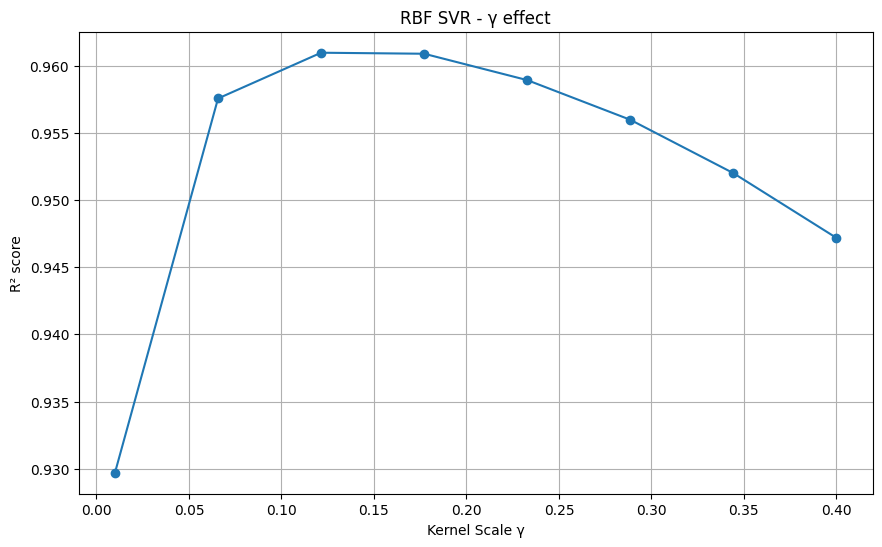

In [32]:
#Gamma vs R2 plot
plt.figure(figsize=(10.24,6.00))
plt.plot(Kernel_scale, R2_rec_gaus, marker='o', linestyle='-')
plt.xlabel('Kernel Scale γ')
plt.ylabel('R² score')
plt.title("RBF SVR - γ effect")
plt.grid(True)
plt.show()

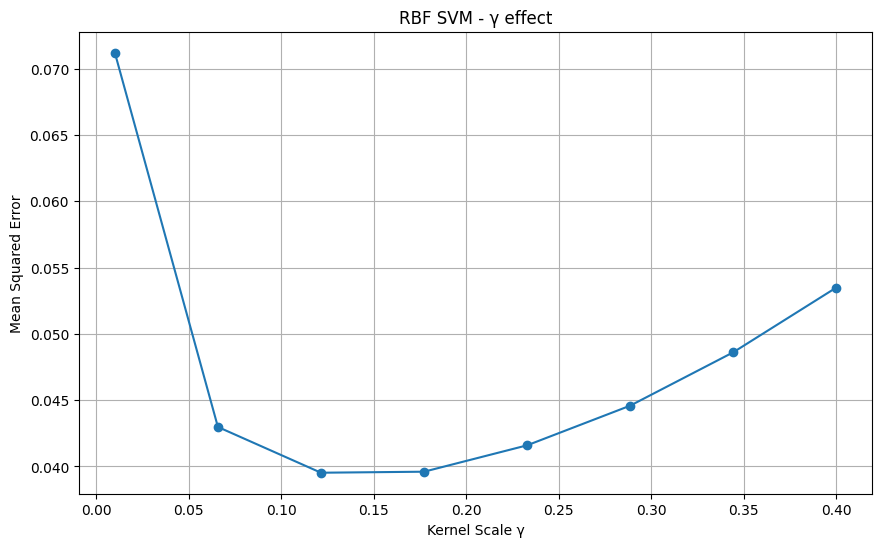

In [33]:
#Gamma vs MSE plot
plt.figure(figsize=(10.24,6.00))
plt.plot(Kernel_scale, MSE_rec_gaus, marker='o', linestyle='-')
plt.xlabel('Kernel Scale γ') 
plt.ylabel('Mean Squared Error')
plt.title("RBF SVM - γ effect")
plt.grid(True)
plt.show()

Optional: Find and tune the best SVM model for the regression problem, you can find better model than solution manual. Solution key R2=0.9762 & MSE=0.02406

In [34]:
#Gaussian SVM
svm_gaus = ...
...
MSE_svmgaus, R2_svmgaus= ...
print("MSE scores of polynomial SVM: "+str(MSE_svmgaus))
print("R2 scores of polynommial SVM: "+str(R2_svmgaus))

TypeError: cannot unpack non-iterable ellipsis object

#### Questions
<br>1) Write and compare results of default and tuned linear SVMs. 
<br>2) Write and compare results of auto and scaled gamma parameters for polynomial SVM. 
<br>3) Write and compare results of different gamma values for RBF SVM.
<br>4) Which model (with parameters) has the highest performance in load forecast problem? 


#### Bonus Task
In this bonus task you have to implement a regression model that predicts the total electricity consumption of a day using only time information in a categorical form.

<br>Some data types cannot be represented as numeric values like day of the month. Entering numeric value of the day can cause last weeks of the month have larger impact on prediction which may affect the prediction capability of many machine learning models. Each numeric value can be transformed into binary representation.

<br>For example, colour of apples 'red' and 'green' can be codded with 2 binary vectors a1 and a2 where a1 represents whether apple is red or not, a2 shows green or not with binary values 1 and 0. ( a1[55]=1 , 56th sample point is a red apple which requires a2[55]=0 because it cannot be both red and green at the same time.)
3 different categorical variables are used to model the time element. Matrix C has a shape of 8592*9. Each coloumn contains a specific categorical binary value. Order of columns in matrix C must be identical with the same order given below.
	<br>a)Weekend and weekday
	<br>b)Seasons: Winter, Spring, Summer, Fall
	<br>c)Hours: Day (07:00-16:00), Peak (17:00-21:00), Night (22:00-06:00)
<br>C=[Weekend,Weekday,Winter,..,Fall,Day,..,Night]

<br>For this task create a new feature matrix or vector X_bonus from the given Input CSV file that can only contain time related features. After that create the vector y_day which contains the total daily consumption level. Finally, create your regressor model, train, and evaluate the model performance. Provide your observations and findings. 


###### End of file - Ignore Remaining Cells ###### 